<a href="https://colab.research.google.com/github/ElizabethEwurabena/CV_ENG_8160/blob/main/HOMEWORK_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Assignment Details

You are provided with two datasets: localization and classification.Localization: provides images and a csv file describing the location of objects in each image. Classification: provides images collated in folders which describe the type of vehicle classes the images belong to. To complete this assignment:


Download and extract both datasets
Use object oriented programming to write a custom data loader to read and transform both datasets. Note that localization will need labels to be transformed also.
The transforms to use should include: resizing of images, horizontal, vertical flip, tensor and normalization of data.
Include custom plotting functions to help visualize data.




Rules
Feel free to use online resources. However, if you use any function or technique not discussed in class, demonstrate your understanding of the technique with at least 2 examples of how to use the function. You will lose points if this is not done
Use google collab only
While you may discuss this homework with your colleagues, your solution should not look too similar to others. You will be penalized for that.
Due Date
The homework is due on Thursday, February 8th at midnight.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/CV_ENG_8160/module 3'

/content/drive/MyDrive/CV_ENG_8160/module 3


In [69]:
## get_item works only for localization
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
import cv2
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


class CustomDataloader(Dataset):
    def __init__(self, local_dir, cls_dir, task_type=None, class_name=None, transform=None):
        self.task_type = task_type
        self.transform = transform
        self.local_dir = local_dir
        self.cls_dir = cls_dir

        # Read CSV files
        self.local_labels_df = pd.read_csv(os.path.join(local_dir, 'train.csv'))
        self.cls_labels_df = pd.read_csv(os.path.join(cls_dir, 'train.csv'))

        # Prepend zeros to filenames in the CSV files
        self.local_labels_df['img_name'] = self.local_labels_df['img_name'].apply(lambda x: str(x).zfill(8)) #zfill new function
        self.cls_labels_df['img_name'] = self.cls_labels_df['img_name'].apply(lambda x: str(x).zfill(8))

        self.local_imgs = os.path.join(local_dir, 'classd')
        self.cls_imgs = os.path.join(cls_dir, 'data')
        self.cls_img_classes = os.listdir(self.cls_imgs)
        self.class_name = class_name


    def __len__(self):
      #get the length of the csv files
        if self.task_type == "classification":
            return len(self.cls_labels_df)
        elif self.task_type == "localization":
            return len(self.local_labels_df)

    def __getitem__(self, idx):
        if self.task_type == "classification":  #classification
          image = None
          label = None
          img_name = str(self.cls_labels_df.iloc[idx, 0]) + '.jpg'
          label = self.cls_labels_df.iloc[idx, 1]
          for class_name in self.cls_img_classes:
              class_img_folder = os.path.join(self.cls_imgs, class_name)
              for filename in os.listdir(class_img_folder):
                  if filename == img_name:
                      img_path = os.path.join(class_img_folder, filename)
                      image = io.imread(img_path)
                      break
              if image is not None:
                  break
          if image is None:
              raise FileNotFoundError(f"Image with index {idx} not found in any class folder")
        elif self.task_type == "localization": #localization
            img_name = str(self.local_labels_df.iloc[idx, 0]) + '.jpg'
            img_path = os.path.join(self.local_imgs, img_name)
            image = io.imread(img_path)
            label = self.local_labels_df.iloc[idx, 1]
        sample = {'image': image, 'label': label}
        return sample

    def normalize_image(self, sample):
        image, label = sample['image'], sample['label']
        image = image / 255.0  # Normalize pixel values to [0, 1]
        return {'image': image, 'label': label}

    def img_visualize(self, idx, image, label):
      if self.task_type == "classification":
          plt.imshow(image)
          plt.title(label)
          plt.axis('off')
          plt.show()
      elif self.task_type == "localization":
          file_name = self.local_labels_df.iloc[idx, 0]
          file_rows = self.local_labels_df[self.local_labels_df.iloc[:, 0] == file_name]
          print(file_name)
          print(file_rows)
          for _, row in file_rows.iterrows():
            x, y, w, h = row[2:]
            x, y, w, h = int(x), int(y), int(w), int(h)
            img=cv2.rectangle(image, (x, y), (w, h), (255, 0, 0), 2)
          plt.imshow(img)
          plt.title(file_name)
          plt.axis('off')
          plt.show()

class Flip(object):
    def __init__(self, flip_type):
        assert flip_type in [0, 1]
        self.flip_type = flip_type
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        if self.flip_type == 1:
            image = np.flip(image, axis=0)  # Vertical flip
        elif self.flip_type == 0:
            image = np.flip(image, axis=1)  # Horizontal flip
        return {'image': image, 'label': label}

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        return {'image': img, 'label': label}

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        print(type(image))
        image = torch.from_numpy(image.transpose((2, 0, 1))).float()
        return {'image': image, 'label': label}

In [47]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

25327


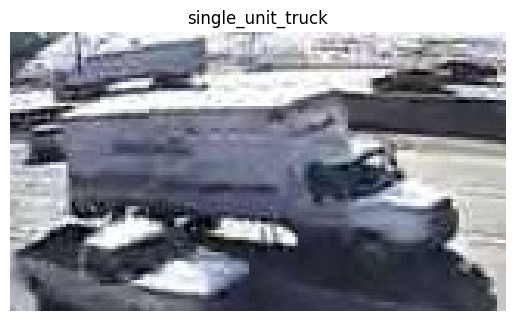

In [53]:
#  CLASSIFICATION

task_type = "classification"
cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name='work_van')
length=len(cls_data)
print(length)
selected_cls_image = cls_data[31]
cls_data.img_visualize(31, selected_cls_image['image'], selected_cls_image['label'])

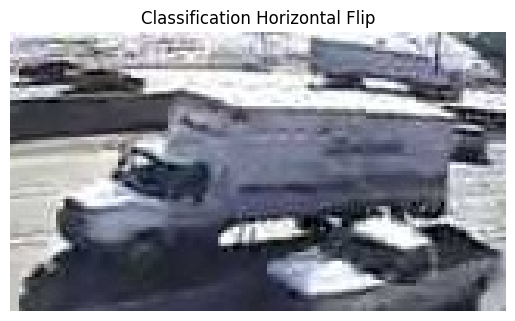

In [54]:
#Transformation

obj= Flip(flip_type=0)  # Horizontal flip
hflip_local = obj(selected_cls_image)
hflip_local = hflip_local['image']
plt.imshow(hflip_local)
plt.title("Classification Horizontal Flip")
plt.axis('off')
plt.show()

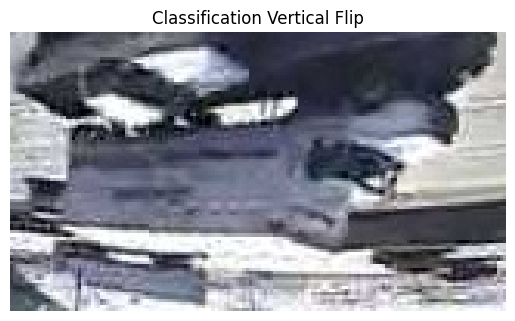

In [55]:
#Transformation

obj= Flip(flip_type=1)  # Vertical flip
hflip_local = obj(selected_cls_image)
hflip_local = hflip_local['image']
plt.imshow(hflip_local)
plt.title("Classification Vertical Flip")
plt.axis('off')
plt.show()

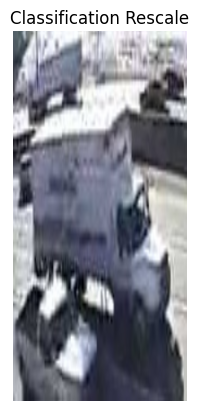

In [62]:
#Transformation

obj= Rescale(output_size=(640, 300))  # rescale
rescale_local = obj(selected_cls_image)
rescale_local = rescale_local['image']
plt.imshow(rescale_local)
plt.title("Classification Rescale")
plt.axis('off')
plt.show()

In [67]:
#classification data to tensor

obj = ToTensor()
custom_dataset = obj(selected_cls_image)
custom_dataset

<class 'numpy.ndarray'>


{'image': tensor([[[ 80.,  83.,  84.,  ..., 254., 239., 242.],
          [ 87.,  83.,  85.,  ..., 237., 231., 249.],
          [ 79.,  81.,  76.,  ..., 195., 216., 245.],
          ...,
          [185., 181., 175.,  ..., 188., 199., 197.],
          [166., 174., 194.,  ..., 195., 199., 192.],
          [147., 157., 184.,  ..., 199., 197., 198.]],
 
         [[ 93.,  96.,  97.,  ..., 250., 232., 235.],
          [100.,  96.,  98.,  ..., 233., 224., 242.],
          [ 89.,  91.,  89.,  ..., 193., 212., 241.],
          ...,
          [188., 184., 178.,  ..., 190., 200., 198.],
          [169., 177., 197.,  ..., 197., 200., 193.],
          [150., 160., 187.,  ..., 201., 198., 199.]],
 
         [[101., 104., 103.,  ..., 255., 248., 251.],
          [108., 104., 104.,  ..., 247., 240., 255.],
          [ 98., 100.,  95.,  ..., 206., 227., 255.],
          ...,
          [195., 191., 185.,  ..., 187., 195., 193.],
          [176., 184., 204.,  ..., 194., 195., 188.],
          [157., 167.,

1000
00068843
     img_name vclass   x1   y1   x2   y2
31   00068843    car  384  192  455  217
109  00068843    car  587  260  704  339


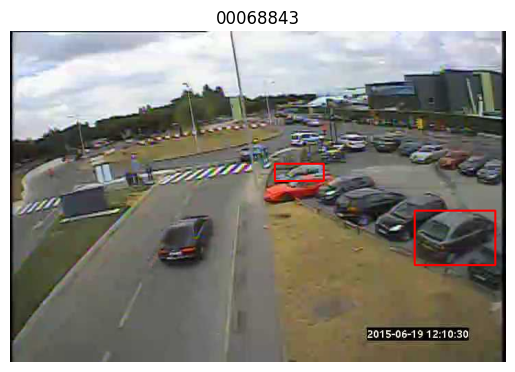

In [64]:
# LOCALIZATION

task_type = "localization"
custom_data = CustomDataloader(local_dir, cls_dir, task_type, class_name='work_van')
length=len(custom_data)
print(length)
selected_image = custom_data[31]
custom_data.img_visualize(31, selected_image['image'], selected_image['label'])

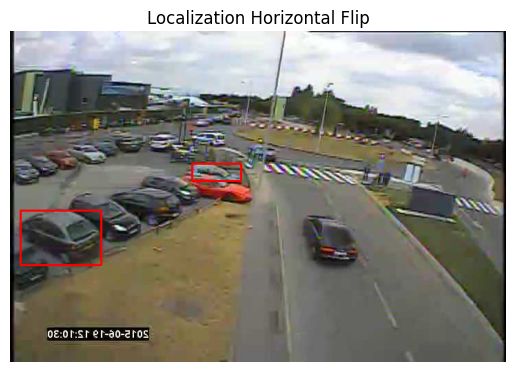

In [50]:
#Transformation

obj= Flip(flip_type=0)  # Horizontal flip
hflip_local = obj(selected_image)
hflip_local = hflip_local['image']
plt.imshow(hflip_local)
plt.title("Localization Horizontal Flip")
plt.axis('off')
plt.show()


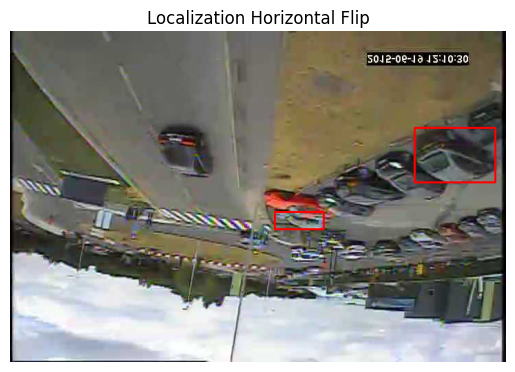

In [51]:
#Transformation

obj= Flip(flip_type=1)  # Vertical flip
hflip_local = obj(selected_image)
hflip_local = hflip_local['image']
plt.imshow(hflip_local)
plt.title("Localization Horizontal Flip")
plt.axis('off')
plt.show()

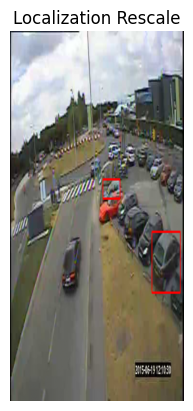

In [65]:
#Transformation

obj= Rescale(output_size=(640, 300))  # rescale
rescale_local = obj(selected_image)
rescale_local = rescale_local['image']
plt.imshow(rescale_local)
plt.title("Localization Rescale")
plt.axis('off')
plt.show()

In [66]:
#Localization data to tensor

obj = ToTensor()
custom_dataset = obj(selected_image)
custom_dataset

<class 'numpy.ndarray'>


{'image': tensor([[[ 2.,  1.,  3.,  ..., 14., 14., 14.],
          [13.,  3.,  4.,  ..., 14., 14., 14.],
          [14.,  0.,  0.,  ..., 14., 14., 14.],
          ...,
          [ 1.,  3., 20.,  ...,  6., 10., 15.],
          [ 1.,  3., 20.,  ...,  6., 10., 15.],
          [ 1.,  3., 20.,  ...,  6., 10., 15.]],
 
         [[ 9.,  8., 10.,  ..., 14., 14., 14.],
          [20., 10., 11.,  ..., 14., 14., 14.],
          [21.,  1.,  1.,  ..., 14., 14., 14.],
          ...,
          [ 2.,  4., 21.,  ...,  1.,  5., 10.],
          [ 2.,  4., 21.,  ...,  1.,  5., 10.],
          [ 2.,  4., 21.,  ...,  1.,  5., 10.]],
 
         [[19., 18., 20.,  ..., 16., 14., 14.],
          [30., 20., 21.,  ..., 16., 14., 14.],
          [31., 11., 11.,  ..., 16., 14., 14.],
          ...,
          [ 0.,  0., 13.,  ...,  5., 11., 16.],
          [ 0.,  0., 13.,  ...,  5., 11., 16.],
          [ 0.,  0., 13.,  ...,  5., 11., 16.]]]),
 'label': 'car'}

In [35]:
##example use of zfill

txt = "50"

x = txt.zfill(10) #prepends a number of zeros to a string to get the specified string length

print(x)



0000000050


In [36]:
##example use of zfill

img = "1250"

img = txt.zfill(5)

print(img)

00050


In [ ]:
#example use of cv2.rectangle

# This uses the open cv library to draw a rectangle of a specific color and thickness
# as used in the code above the choosen color (255, 0, 0) is red because 255 is in the red part of the RGB
# the chosen thickness is 2 pixels and the (x,y) from the bounding box coordinates are the starting point and the (w,h) is the endpoint.
#example can be seen in its usage in the code

image = cv2.rectangle(image, start_point, end_point, color, thickness)

img=cv2.rectangle(image, (x, y), (w, h), (255, 0, 0), 2)

In [70]:
  #  CLASSIFICATION image normalization

task_type = "classification"
cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name='work_van')
length=len(cls_data)
print(length)
selected_cls_image = cls_data[31]
cls_data.normalize_image(selected_cls_image)



25327


{'image': array([[[0.31372549, 0.36470588, 0.39607843],
         [0.3254902 , 0.37647059, 0.40784314],
         [0.32941176, 0.38039216, 0.40392157],
         ...,
         [0.99607843, 0.98039216, 1.        ],
         [0.9372549 , 0.90980392, 0.97254902],
         [0.94901961, 0.92156863, 0.98431373]],
 
        [[0.34117647, 0.39215686, 0.42352941],
         [0.3254902 , 0.37647059, 0.40784314],
         [0.33333333, 0.38431373, 0.40784314],
         ...,
         [0.92941176, 0.91372549, 0.96862745],
         [0.90588235, 0.87843137, 0.94117647],
         [0.97647059, 0.94901961, 1.        ]],
 
        [[0.30980392, 0.34901961, 0.38431373],
         [0.31764706, 0.35686275, 0.39215686],
         [0.29803922, 0.34901961, 0.37254902],
         ...,
         [0.76470588, 0.75686275, 0.80784314],
         [0.84705882, 0.83137255, 0.89019608],
         [0.96078431, 0.94509804, 1.        ]],
 
        ...,
 
        [[0.7254902 , 0.7372549 , 0.76470588],
         [0.70980392, 0.72156863